# **PHASE 1**

In [1]:
import os, io, gzip, time, random, traceback
from pathlib import Path
from PIL import Image, ImageFile, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image
from torchvision.transforms import InterpolationMode
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
# -------------------------
# CONFIG: tweak these for speed / full runs
# -------------------------
class CFG:
    # dataset roots (change if different)
    NIH_ROOT = "/kaggle/input/data"
    CHEXPERT_ROOT = "/kaggle/input/chexpert/CheXpert-v1.0-small"
    MIMIC_ROOT = "/kaggle/input/mimic-cxr-dataset/official_data_iccv_final/files"
    RSNA_ROOT = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"  # not used by default

    # model + training hyperparams
    BACKBONE = "resnet18"   # "resnet18" or "resnet50"
    IMAGE_SIZE = 224        # reduce to 160 for faster runs (recommended in FAST_MODE)
    PATCH_SIZE = 16
    ENCODER_OUT_DIM = 512   # resnet18
    PROJ_DIM = 128
    MAE_DECODER_DIM = 256

    # speed controls
    BATCH_SIZE = 64         # set to 128 if GPU memory allows
    EPOCHS = 10             # reduced from 40 -> 10 for fast runs
    FAST_MODE = True        # when True, caps dataset (see FAST_MAX_IMAGES)
    FAST_MAX_IMAGES = 25_000  # cap for FAST_MODE (approx batches = FAST_MAX_IMAGES / BATCH_SIZE)

    # optimizer / losses
    LR = 1e-4
    WEIGHT_DECAY = 1e-2
    TAU = 0.1
    LAMBDA_C = 1.0
    LAMBDA_M = 1.0
    LAMBDA_XM = 0.0

    # runtime
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CHECKPOINT_DIR = "./checkpoints"
    SAVE_FINAL_COMPRESSED = True  # save final compressed checkpoint
    FORCE_SINGLE_PROCESS = True   # safe for Kaggle; set False on local multi-core
    NUM_WORKERS = 0               # overridden by make_dataloader fallback if needed
    GRAD_ACCUM_STEPS = 1

cfg = CFG()

# reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
os.makedirs(cfg.CHECKPOINT_DIR, exist_ok=True)

In [3]:
# -------------------------
# PIL safety
# -------------------------
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.warnings.simplefilter("ignore", Image.DecompressionBombWarning)

In [4]:
# -------------------------
# Utilities: listing + quick filter
# -------------------------
def list_images(root):
    root = Path(root)
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    if not root.exists():
        return []
    return [str(p) for p in root.rglob("*") if p.suffix.lower() in exts]

def quick_scan_and_filter(paths, max_check=20000):
    """Lightweight scan using PIL.verify() to remove obvious corrupt images.
       Limits to max_check files to avoid long startup time.
    """
    good = []
    checked = 0
    for p in paths:
        if checked >= max_check:
            good += paths[checked:]
            break
        checked += 1
        try:
            with Image.open(p) as im:
                im.verify()
            good.append(p)
        except Exception:
            continue
    # Safety: if too few passed, return original to avoid accidental overfiltering
    if len(good) < max(100, 0.1 * len(paths)):
        return paths
    return good

In [5]:
# -------------------------
# Build global file list (NIH, CheXpert, MIMIC) - skip RSNA by default
# -------------------------
paths = []
print("Listing NIH images...")
if Path(cfg.NIH_ROOT).exists():
    # many NIH splits live in subfolders; try both
    for i in range(1, 13):
        sub = Path(cfg.NIH_ROOT) / f"images_{i:03d}"
        if sub.exists():
            paths += list_images(sub)
    paths += list_images(cfg.NIH_ROOT)

print("Listing CheXpert images...")
if Path(cfg.CHEXPERT_ROOT).exists():
    paths += list_images(Path(cfg.CHEXPERT_ROOT) / "train")
    paths += list_images(Path(cfg.CHEXPERT_ROOT) / "valid")

print("Listing MIMIC images...")
if Path(cfg.MIMIC_ROOT).exists():
    for pdir in sorted(Path(cfg.MIMIC_ROOT).glob("p*")):
        paths += list_images(pdir)

print("Skipping RSNA dataset for Phase 1 (optional).")
paths = list(dict.fromkeys(paths))  # deduplicate
print(f"✅ Found {len(paths):,} images (before filtering).")

# quick scan
print("[INFO] Running quick corrupt-file scan (fast).")
paths = quick_scan_and_filter(paths, max_check=20000)
print(f"[INFO] After quick scan: {len(paths):,} usable images")

# FAST_MODE cap (reduce dataset size to make quick experiments)
if cfg.FAST_MODE:
    if len(paths) > cfg.FAST_MAX_IMAGES:
        random.shuffle(paths)
        paths = paths[:cfg.FAST_MAX_IMAGES]
    print(f"[FAST MODE] Using {len(paths):,} images (cap={cfg.FAST_MAX_IMAGES})")

Listing NIH images...
Listing CheXpert images...
Listing MIMIC images...
Skipping RSNA dataset for Phase 1 (optional).
✅ Found 596,906 images (before filtering).
[INFO] Running quick corrupt-file scan (fast).
[INFO] After quick scan: 596,906 usable images
[FAST MODE] Using 25,000 images (cap=25000)


In [6]:
# -------------------------
# Augmentations
# -------------------------
base_transforms = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
mae_target_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [7]:
# -------------------------
# Robust dataset (PIL-first then torchvision)
# -------------------------
class RobustMultiViewXrayDataset(Dataset):
    def __init__(self, image_paths, transform_view, mae_target_transform, max_retries=3):
        self.paths = [p for p in image_paths if not Path(p).name.startswith("._")]
        self.transform_view = transform_view
        self.mae_target_transform = mae_target_transform
        self.max_retries = max_retries

    def __len__(self): return len(self.paths)

    def _safe_load(self, path):
        # try PIL first (most stable). fallback to torchvision.read_image
        for _ in range(self.max_retries):
            try:
                im = Image.open(path)
                return im.convert("RGB")
            except Exception:
                try:
                    t = read_image(path).float() / 255.0
                    from torchvision.transforms.functional import to_pil_image
                    return to_pil_image(t)
                except Exception:
                    path = random.choice(self.paths)
                    continue
        # final fallback: constant black image
        return Image.new("RGB", (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), color=(0,0,0))

    def __getitem__(self, idx):
        try:
            p = self.paths[idx]
            img = self._safe_load(p)
            v1 = self.transform_view(img)
            v2 = self.transform_view(img)
            tgt = self.mae_target_transform(img)
            return v1, v2, tgt, p
        except Exception as e:
            # deterministic dummy so workers don't crash
            print(f"[WARN] dataset __getitem__ failed idx={idx}: {e}")
            dummy_view = torch.zeros((3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), dtype=torch.float32)
            dummy_tgt = torch.zeros((1, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), dtype=torch.float32)
            return dummy_view, dummy_view.clone(), dummy_tgt, "CORRUPT"

In [8]:
# -------------------------
# Split and create datasets
# -------------------------
random.shuffle(paths)
split = int(0.9 * len(paths))
train_paths, val_paths = paths[:split], paths[split:]
print(f"[INFO] Train: {len(train_paths):,}, Val: {len(val_paths):,}")

train_ds = RobustMultiViewXrayDataset(train_paths, base_transforms, mae_target_transform)
val_ds   = RobustMultiViewXrayDataset(val_paths, base_transforms, mae_target_transform)

[INFO] Train: 22,500, Val: 2,500


In [9]:
# -------------------------
# Robust dataloader factory (fallback to fewer workers)
# -------------------------
def make_dataloader_with_fallback(dataset, train=True):
    if cfg.FORCE_SINGLE_PROCESS:
        candidates = [0]
    else:
        candidates = [min(8, os.cpu_count()), 4, 2, 1, 0]

    last_exc = None
    for nw in candidates:
        try:
            dl = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=train,
                            num_workers=nw, pin_memory=False, persistent_workers=False,
                            prefetch_factor=2 if nw>0 else None)
            # smoke-test
            _ = next(iter(dl))
            print(f"[INFO] DataLoader created (train={train}) num_workers={nw}")
            return dl
        except Exception as e:
            last_exc = e
            print(f"[WARN] DataLoader num_workers={nw} failed: {e}")
            continue
    raise RuntimeError(f"Could not create DataLoader; last error: {last_exc}")

train_loader = make_dataloader_with_fallback(train_ds, train=True)
val_loader   = make_dataloader_with_fallback(val_ds, train=False)
print(f"[OK] Train batches: {len(train_loader):,} | Val batches: {len(val_loader):,}")

[INFO] DataLoader created (train=True) num_workers=0
[INFO] DataLoader created (train=False) num_workers=0
[OK] Train batches: 352 | Val batches: 40


In [10]:
# -------------------------
# Model: backbone + projection + MAE-lite
# -------------------------
def build_backbone(backbone_name="resnet18", pretrained=True):
    if backbone_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
    elif backbone_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
    else:
        raise ValueError("Unsupported backbone")
    model.fc = nn.Identity()
    return model

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, proj_dim)
        )
    def forward(self, x): return self.net(x)

class MAELiteDecoder(nn.Module):
    def __init__(self, encoder_out_dim, patch_size, image_size, decoder_dim, out_channels=1):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.grid = image_size // patch_size
        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_dim, decoder_dim),
            nn.ReLU(inplace=True),
            nn.Linear(decoder_dim, patch_size * patch_size * out_channels)
        )
    def forward(self, feat_map):
        pooled = F.adaptive_avg_pool2d(feat_map, (self.grid, self.grid))  # B,C,g,g
        B, C, g, _ = pooled.shape
        tokens = pooled.flatten(2).permute(0,2,1)  # B, num_patches, C
        patches = self.decoder(tokens)  # B, num_patches, p*p*1
        patches = patches.view(B, self.grid, self.grid, 1, self.patch_size, self.patch_size)
        recon = patches.permute(0,3,1,4,2,5).reshape(B,1,self.image_size,self.image_size)
        return recon

class SSLModel(nn.Module):
    def __init__(self, backbone="resnet18", pretrained=True):
        super().__init__()
        self.encoder = build_backbone(backbone, pretrained)
        enc_out = cfg.ENCODER_OUT_DIM
        self.proj = ProjectionHead(enc_out, cfg.PROJ_DIM)
        self.mae_decoder = MAELiteDecoder(enc_out, cfg.PATCH_SIZE, cfg.IMAGE_SIZE, cfg.MAE_DECODER_DIM)
    def forward(self, x, return_map=False):
        # Forward up to layer4 to get spatial map
        x = self.encoder.conv1(x); x = self.encoder.bn1(x); x = self.encoder.relu(x); x = self.encoder.maxpool(x)
        x = self.encoder.layer1(x); x = self.encoder.layer2(x); x = self.encoder.layer3(x)
        feat_map = self.encoder.layer4(x)  # B,C,H',W'
        pooled = torch.flatten(self.encoder.avgpool(feat_map), 1)
        z = F.normalize(self.proj(pooled), dim=1)
        return (z, feat_map) if return_map else z

# instantiate
model = SSLModel(cfg.BACKBONE, pretrained=True).to(cfg.DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# -------------------------
# losses and optimizer
# -------------------------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def forward(self, zis, zjs):
        B = zis.shape[0]
        z = torch.cat([zis, zjs], dim=0)  # 2B x D
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / self.temperature
        mask = (~torch.eye(2*B, dtype=bool, device=z.device)).float()
        exp_sim = torch.exp(sim) * mask
        positives = torch.exp(F.cosine_similarity(zis, zjs, dim=1) / self.temperature)
        positives = torch.cat([positives, positives], dim=0)
        denom = exp_sim.sum(dim=1)
        loss = -torch.log(positives / denom)
        return loss.mean()

nt_xent = NTXentLoss(cfg.TAU)
mae_loss_fn = lambda recon, target: F.mse_loss(recon, target)

optimizer = AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.DEVICE=="cuda"))

/tmp/ipykernel_136/103372100.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.DEVICE=="cuda"))


Starting Phase-1 SSL pretraining: epochs=10, batch_size=64, device=cuda


Epoch 01 | Train=0.2458 | Val=0.0904


Epoch 02 | Train=0.0700 | Val=0.0697


Epoch 03 | Train=0.0592 | Val=0.0620


Epoch 04 | Train=0.0534 | Val=0.0568


Epoch 05 | Train=0.0498 | Val=0.0532


Epoch 06 | Train=0.0470 | Val=0.0504


Epoch 07 | Train=0.0455 | Val=0.0492


Epoch 08 | Train=0.0437 | Val=0.0485


Epoch 09 | Train=0.0424 | Val=0.0461


Epoch 10 | Train=0.0416 | Val=0.0448
Saving final artifacts...
Saved compressed final checkpoint.
Phase-1 complete in 90.3 min — saved ssl_backbone.pt and proj_head.pt


Extract Feats: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


Feature extraction skipped or failed: dump() missing required argument 'file' (pos 2)


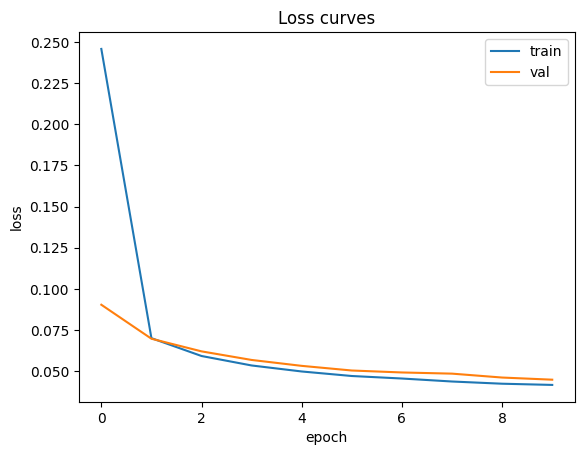

In [12]:
# -------------------------
# training loop (minimal IO, save final only)
# -------------------------
train_losses, val_losses = [], []
start_time = time.time()
print(f"Starting Phase-1 SSL pretraining: epochs={cfg.EPOCHS}, batch_size={cfg.BATCH_SIZE}, device={cfg.DEVICE}")

for epoch in range(1, cfg.EPOCHS+1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False)
    for step, (v1, v2, mae_tgt, _) in enumerate(pbar):
        v1 = v1.to(cfg.DEVICE, non_blocking=True)
        v2 = v2.to(cfg.DEVICE, non_blocking=True)
        mae_tgt = mae_tgt.to(cfg.DEVICE, non_blocking=True)
        with torch.amp.autocast(device_type="cuda", enabled=(cfg.DEVICE=="cuda")):
            z1, f1 = model(v1, return_map=True)
            z2, f2 = model(v2, return_map=True)
            loss_c = nt_xent(z1, z2) * cfg.LAMBDA_C
            recon1 = model.mae_decoder(f1)
            recon2 = model.mae_decoder(f2)
            loss_m = 0.5 * (mae_loss_fn(recon1, mae_tgt) + mae_loss_fn(recon2, mae_tgt)) * cfg.LAMBDA_M
            loss = loss_c + loss_m
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{running_loss / (step+1):.4f}"})
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for v1, v2, mae_tgt, _ in tqdm(val_loader, desc="Val", leave=False):
            v1 = v1.to(cfg.DEVICE, non_blocking=True)
            v2 = v2.to(cfg.DEVICE, non_blocking=True)
            mae_tgt = mae_tgt.to(cfg.DEVICE, non_blocking=True)
            z1, f1 = model(v1, return_map=True)
            z2, f2 = model(v2, return_map=True)
            val_loss += (nt_xent(z1, z2) + mae_loss_fn(model.mae_decoder(f1), mae_tgt)).item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:02d} | Train={train_loss:.4f} | Val={val_loss:.4f}")

# save final artifacts
print("Saving final artifacts...")
if cfg.SAVE_FINAL_COMPRESSED:
    buf = io.BytesIO()
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "cfg": cfg.__dict__,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, buf, pickle_protocol=4)
    buf.seek(0)
    with gzip.open(Path(cfg.CHECKPOINT_DIR) / "final_checkpoint.pth.gz", "wb", compresslevel=5) as f:
        f.write(buf.read())
    print("Saved compressed final checkpoint.")

torch.save(model.encoder.state_dict(), "ssl_backbone.pt")
torch.save(model.proj.state_dict(), "proj_head.pt")
plt.figure(); plt.plot(train_losses, label="train"); plt.plot(val_losses, label="val")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curves")
plt.savefig("loss_curves.png", dpi=200)
elapsed = (time.time() - start_time)/60.0
print(f"Phase-1 complete in {elapsed:.1f} min — saved ssl_backbone.pt and proj_head.pt")

# Optional: extract validation embeddings for quick t-SNE (small subset)
try:
    model.eval()
    feats, paths_meta = [], []
    with torch.no_grad():
        for v1, v2, mae_tgt, paths_ in tqdm(val_loader, desc="Extract Feats"):
            v = v1.to(cfg.DEVICE)
            z, fmap = model(v, return_map=True)
            feats.append(z.cpu().numpy())
            paths_meta += list(paths_)
    feats = np.concatenate(feats, axis=0)
    import pickle
    with open("features.pkl", "wb") as f:
        pickle.dump({"feats": feats, "paths": paths_meta})
    print("Saved features.pkl")
except Exception as e:
    print("Feature extraction skipped or failed:", e)

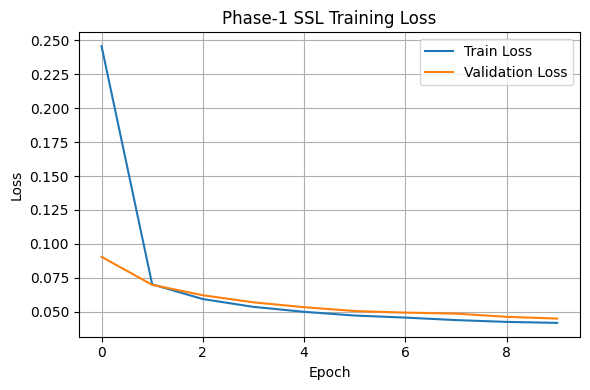

In [13]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Phase-1 SSL Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

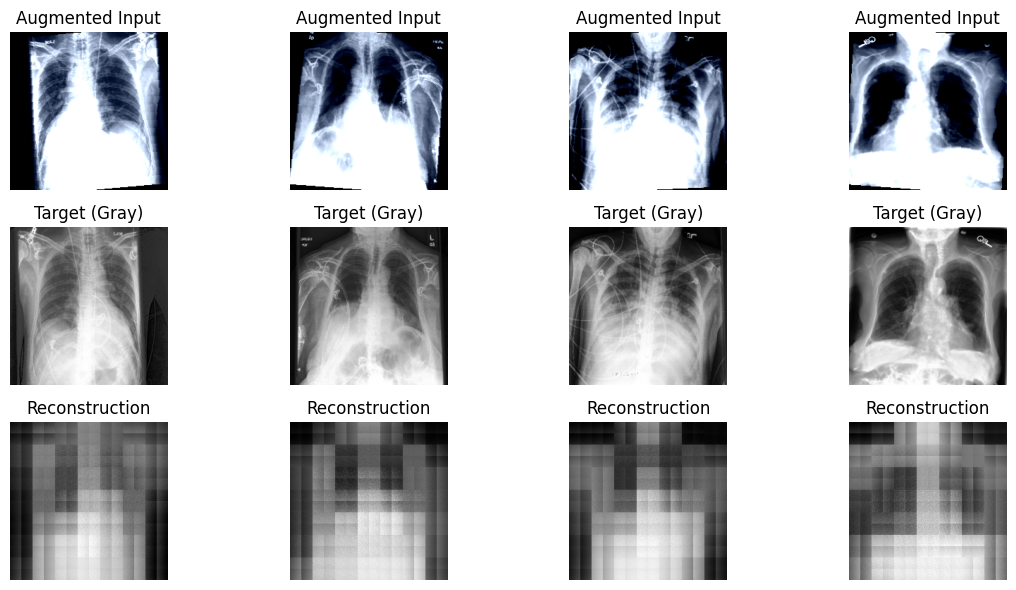

In [15]:
import matplotlib.pyplot as plt

model.eval()
v1, v2, mae_tgt, _ = next(iter(val_loader))
v1 = v1.to(cfg.DEVICE)
with torch.no_grad():
    _, fmap = model(v1, return_map=True)
    recon = model.mae_decoder(fmap)

# visualize few examples
k = 4  # show 4 examples
fig, axs = plt.subplots(3, k, figsize=(k*3, 6))
for i in range(k):
    axs[0,i].imshow(v1[i].cpu().permute(1,2,0).numpy()*0.5 + 0.5)
    axs[0,i].set_title("Augmented Input")
    axs[0,i].axis('off')
    axs[1,i].imshow(mae_tgt[i].cpu().squeeze(), cmap='gray')
    axs[1,i].set_title("Target (Gray)")
    axs[1,i].axis('off')
    axs[2,i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axs[2,i].set_title("Reconstruction")
    axs[2,i].axis('off')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


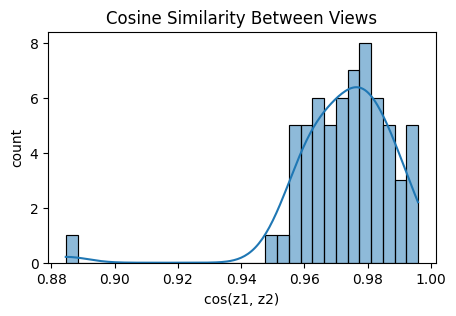

In [16]:
import seaborn as sns

model.eval()
v1, v2, _, _ = next(iter(val_loader))
v1, v2 = v1.to(cfg.DEVICE), v2.to(cfg.DEVICE)
with torch.no_grad():
    z1, _ = model(v1, return_map=True)
    z2, _ = model(v2, return_map=True)
sim = F.cosine_similarity(z1, z2, dim=1).cpu().numpy()

plt.figure(figsize=(5,3))
sns.histplot(sim, bins=30, kde=True)
plt.title("Cosine Similarity Between Views")
plt.xlabel("cos(z1, z2)")
plt.ylabel("count")
plt.show()